In [1]:
!pip install torch torchvision torchaudio torch_geometric memory_profiler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

Processing...
Done!


GAT - Accuracy: 0.7810, F1: 0.7814, Time: 5.00s, Memory: 836.59MB
GraphSAGE - Accuracy: 0.7300, F1: 0.7317, Time: 6.73s, Memory: 902.22MB


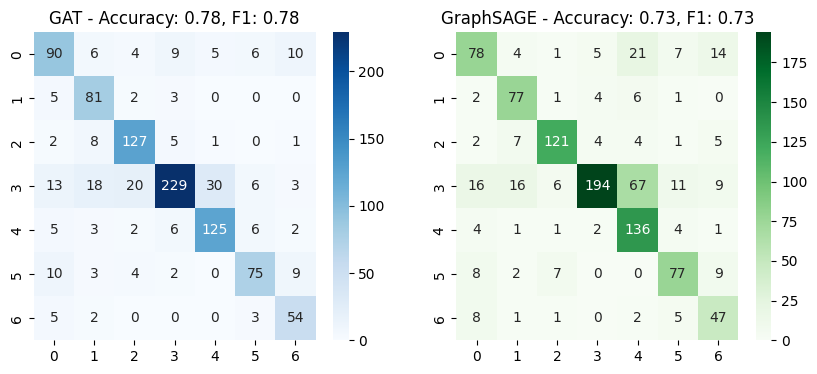

In [2]:
import time
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv, SAGEConv
from torch.optim import Adam
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0]

class GATModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=8, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * 8, output_dim, heads=1, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.elu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

class GraphSAGEModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

def train_model(model):
    optimizer = Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.CrossEntropyLoss()

    def train():
        model.train()
        for epoch in range(50):
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

    start_time = time.time()
    mem_usage = memory_usage((train,), max_iterations=1)
    end_time = time.time()

    return end_time - start_time, max(mem_usage)

def evaluate_model(model):
    model.eval()
    with torch.no_grad():
        out = model(data)
        y_pred = out[data.test_mask].argmax(dim=1)
        y_true = data.y[data.test_mask]

    acc = accuracy_score(y_true.numpy(), y_pred.numpy())
    f1 = f1_score(y_true.numpy(), y_pred.numpy(), average='weighted')
    cm = confusion_matrix(y_true.numpy(), y_pred.numpy())

    return acc, f1, cm

gat_model = GATModel(dataset.num_features, 16, dataset.num_classes)
gat_time, gat_memory = train_model(gat_model)
gat_acc, gat_f1, gat_cm = evaluate_model(gat_model)

sage_model = GraphSAGEModel(dataset.num_features, 16, dataset.num_classes)
sage_time, sage_memory = train_model(sage_model)
sage_acc, sage_f1, sage_cm = evaluate_model(sage_model)

print(f"GAT - Accuracy: {gat_acc:.4f}, F1: {gat_f1:.4f}, Time: {gat_time:.2f}s, Memory: {gat_memory:.2f}MB")
print(f"GraphSAGE - Accuracy: {sage_acc:.4f}, F1: {sage_f1:.4f}, Time: {sage_time:.2f}s, Memory: {sage_memory:.2f}MB")

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(gat_cm, annot=True, cmap="Blues", fmt="d", ax=ax[0])
ax[0].set_title(f"GAT - Accuracy: {gat_acc:.2f}, F1: {gat_f1:.2f}")

sns.heatmap(sage_cm, annot=True, cmap="Greens", fmt="d", ax=ax[1])
ax[1].set_title(f"GraphSAGE - Accuracy: {sage_acc:.2f}, F1: {sage_f1:.2f}")

plt.show()
